# Task 2
In this task, ConvNext model will be used to perform lens classification. First a config file will be created containing the hyperparameters of the experiment. Then a script will be executed to initiate the training process and the model checkpoint will be saved. Finally, ROC curve and AUC score will be calculated. 




## Dataset preparation

Dataset has been split in the following way:
- Train set and test set are split into 90:10 ratio as per the instructions.
- Within the train set 95:5 ratio is used to split into train and validation

More can be found on `utils/dataset.py`

In [1]:
from torchvision import transforms
import os
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F 
from utils import get_model, generate_model_outputs, get_dataset_t2
import pandas as pd
from astropy.io import fits
import re

In [ ]:

class FitDataset(Dataset):
    def __init__(self, folder_path: str, label_file: str):

        self.folder_path = folder_path
        self.label_file = label_file
        self.filenames = os.listdir(self.folder_path)
        self.csv_file = pd.read_csv(self.label_file)
        self.labels = self.csv_file["is_lens"].values

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):

        filename = os.path.join(self.folder_path, self.filenames[index])
        ID = re.findall("\d+", self.filenames[index])[0]

        df = self.csv_file.loc[self.csv_file["ID"] == int(ID)]
        label = df["is_lens"].values

        with fits.open(filename) as hdul:
            data = hdul[0].data

        data = data.astype(np.float32)
        tensor_data = torch.from_numpy(data).float().unsqueeze(dim=0)

        return tensor_data, label[0]


def get_dataset_t2(dataset_dir: str, batch_size: int = 16):
    training_dir = os.path.join(dataset_dir, "files")
    label_file = os.path.join(dataset_dir, "classifications.csv")
    ds = FitDataset(training_dir, label_file=label_file)

    # Split ratio 90-10 for train-test
    train_idx, test_idx = train_test_split(
        np.arange(len(ds)), test_size=0.1, shuffle=True, stratify=ds.labels
    )

    train_labels = ds.labels

    # Split ratio for new train set into train and val 95-5
    train_idx, val_idx = train_test_split(
        np.arange(len(train_idx)),
        test_size=0.05,
        shuffle=True,
        stratify=train_labels[train_idx],
    )

    train_ds = Subset(ds, indices=train_idx)
    val_ds = Subset(ds, indices=val_idx)
    test_ds = Subset(ds, indices=test_idx)

    # print(f"train_ds : {len(train_ds)}, val_ds: {len(val_ds)}, test_ds: {len(test_ds)}")
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

## Create config file


In [ ]:
conf = """


exp:
  cache: 2
  data_dir: /media/saitomar/Work/Projects/DeepLense_Test/task_2_dataset
  device: cuda
  exp_dir: ./runs
  exp_name: Task2-ConvNext-0.1
  log_freq: 20
  log_to_file: false
  log_to_stdout: true
  n_workers: 1
  pin_memory: true
  proj_name: DeepLense
  save_dir: ./runs/Task2-ConvNext-0.1
  task: t2
  val_freq: 1
  wandb: true
  wandb_api_key: /media/saitomar/Work/Projects/DeepLense_Test/api_key.txt
hparams:
  batch_size: 16
  device: cuda
  l_smooth: null
  model:
    ConvNext_backbone:
      in_channels: 1
      num_classes: 2
    type: ConvNext_backbone
  n_epochs: 20
  num_classes: 2
  optimizer:
    opt_kwargs:
      lr: 0.005
    opt_type: adamw
  restore_ckpt: null
  scheduler:
    max_epochs: 20
    n_warmup: 10
    scheduler_type: cosine_annealing

"""

with open("sample_config/config.yaml", "w+") as f:
    f.write(conf)

## Initiate training

In [ ]:
# !python3 pipeline.py --conf sample_config/config.yaml

# ROC curve and AUC score

### Load model ckpt

In [2]:
model_cfg_dict = {
    "type" : "ConvNext_backbone",
    "ConvNext_backbone" : {
        "in_channels" : 1,
        "num_classes" : 2
    }
}

model = get_model(model_config=model_cfg_dict)
ckpt = torch.load(f='/media/saitomar/Work/Projects/DeepLense_Test/runs/Task2-ConvNext-0.1/best.pth')
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

### Prepare test_dataloader

In [4]:
root_dir = "/media/saitomar/Work/Projects/DeepLense_Test/task_2_dataset"

_, _, test_loader = get_dataset_t2(
        dataset_dir=root_dir
    )

### Get model probabilities and plot ROC_curve and calculate AUC_score

In [6]:
true_labels, class_probs = generate_model_outputs(model=model, test_loader=test_loader, num_classes=2)


In [11]:
# Compute ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(true_labels, class_probs[i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])



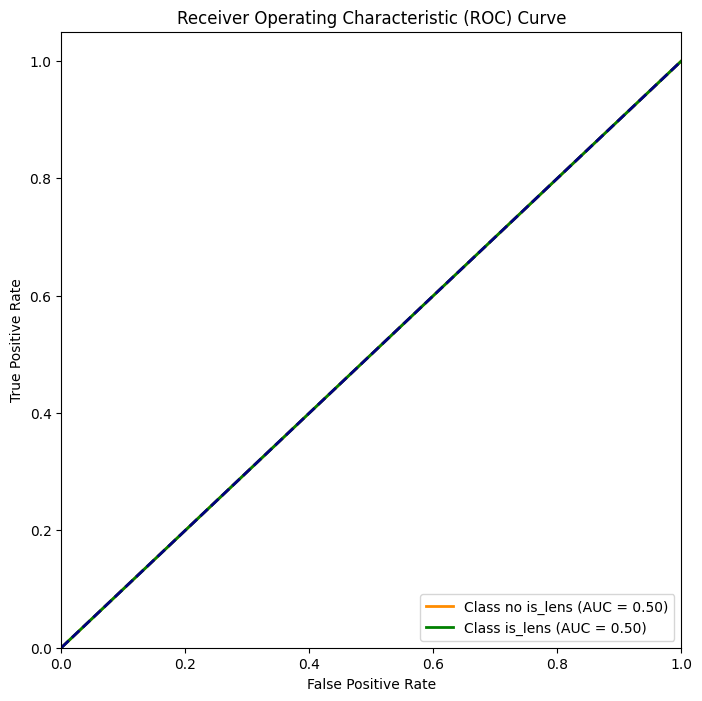

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='Class no is_lens (AUC = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=2, label='Class is_lens (AUC = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()